In [1]:
import math

import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

import basic_net
import dataset as MOFdata

In [2]:

def filter_data(x):
    a, b = -4000, 5000
    mid = (a+b)/2
    dif = b-a
    return np.clip(x, a, b) / dif / 2 - (mid/dif)
    # sigmoid
    # return 1/(1 + np.exp(-np.clip(x, -32, 32)))

grid = "grids.npy"
link = "grids.link"
csv = "ASR.csv"
feature = "LCD"

data = MOFdata.Dataset(grid, link, csv, feature, filter_data)
train_set_size = int(.9 * len(data))
validation_set_size = int(.05 * len(data))
test_set_size = len(data) - train_set_size - validation_set_size
train_set, validation_set, test_set = random_split(
    dataset=data,
    lengths=(train_set_size,
    validation_set_size,
    test_set_size),
    generator=torch.Generator().manual_seed(42))
print(data[0][0].dtype)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

missed 1877
float32


In [3]:
import statistics as stat

lcd = [y for x, y in data]
mean = stat.mean(lcd)
sd = stat.stdev(lcd)

print(mean, sd, min(lcd), max(lcd))

6.828535852311939 3.793682015771011 2.69488 71.64119


In [4]:
model = basic_net.BasicModel().cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [5]:
num_epoch = 150

for epoch in range(num_epoch):
    with tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch") as progress:
        epoch_loss = 0
        ratio_off_mean = 0
        worst = 1
        runs = 0
        batch = 0
        model.train()
        for data_x, data_y in progress:
            batch += 1
            optimizer.zero_grad()

            pred_y = model(data_x.cuda())
            for p, d in zip(pred_y.squeeze(), data_y):
                r = 1 if p == d else 0
                if p > 0 and d > 0:
                    r = abs(p.item() / d.item())
                    r = max(r, 1/r)
                if r > worst:
                    worst = r
                ratio_off_mean += r
                runs += 1
            loss = loss_fn(pred_y, data_y.cuda().float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress.set_postfix(loss=f"{loss.item():3.2f}", ratio=f"{ratio_off_mean/runs:3.2f}",  worst=f"{worst:3.2f}", avg_loss=f"{epoch_loss/batch:3.2f}")
        model.eval()
        ratio_off_mean = 0
        runs = 0
        worst = 0
        for data_x, data_y in validation_loader:
            pred_y = model(data_x.cuda())
            for p, d in zip(pred_y.squeeze(), data_y):
                r = abs(p.item() / d.item())
                r = max(r, 1/r)
                if r > worst:
                    worst = r
                ratio_off_mean += r
                runs += 1
        print(ratio_off_mean/runs, worst)
            
            
    

Epoch 0: 100%|███████████████████████████████████████████████████| 143/143 [00:06<00:00, 20.65batch/s, avg_loss=6.18, loss=3.27, ratio=6.77, worst=21778.58]


1.1830968882171773 1.8067813203901435


Epoch 1: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 26.18batch/s, avg_loss=3.22, loss=1.34, ratio=1.18, worst=3.73]


1.1651309510386176 1.7617773654532112


Epoch 2: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 26.17batch/s, avg_loss=2.89, loss=0.85, ratio=1.17, worst=2.72]


1.159217346041969 1.8031492748533722


Epoch 3: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 26.28batch/s, avg_loss=2.45, loss=1.88, ratio=1.16, worst=3.05]


1.1509333353605469 1.7900309829024998


Epoch 4: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 26.40batch/s, avg_loss=1.77, loss=0.82, ratio=1.13, worst=2.36]


1.1358917040755625 1.6880176138220644


Epoch 5: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.71batch/s, avg_loss=1.55, loss=2.06, ratio=1.13, worst=2.75]


1.126264359590086 1.605186122525249


Epoch 6: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.05batch/s, avg_loss=1.48, loss=2.00, ratio=1.13, worst=2.51]


1.1194385828632263 1.7485745371947252


Epoch 7: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.15batch/s, avg_loss=1.35, loss=1.16, ratio=1.12, worst=2.27]


1.1277853680475984 1.5308261178467941


Epoch 8: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.48batch/s, avg_loss=0.95, loss=0.49, ratio=1.11, worst=2.00]


1.1113276944631982 1.6528360122813104


Epoch 9: 100%|███████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.47batch/s, avg_loss=1.02, loss=0.46, ratio=1.11, worst=2.34]


1.1008387789608598 1.5202449211496079


Epoch 10: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.51batch/s, avg_loss=0.94, loss=1.26, ratio=1.11, worst=1.95]


1.1126062949249782 1.611479874682599


Epoch 11: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.35batch/s, avg_loss=0.86, loss=0.83, ratio=1.11, worst=1.70]


1.1296255540812974 1.5436630975974834


Epoch 12: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.42batch/s, avg_loss=0.74, loss=0.63, ratio=1.10, worst=1.93]


1.0966313481704173 1.5422210325411587


Epoch 13: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.55batch/s, avg_loss=0.69, loss=0.89, ratio=1.09, worst=1.90]


1.157594655431079 1.7732725862656753


Epoch 14: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.52batch/s, avg_loss=0.83, loss=0.55, ratio=1.10, worst=1.78]


1.099394905471948 1.5141803965831149


Epoch 15: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.42batch/s, avg_loss=0.62, loss=0.43, ratio=1.09, worst=1.75]


1.1056942132269885 1.460101705147043


Epoch 16: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.55batch/s, avg_loss=0.49, loss=0.33, ratio=1.08, worst=1.67]


1.0828077630332047 1.4795315391643993


Epoch 17: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.54batch/s, avg_loss=0.57, loss=0.14, ratio=1.09, worst=1.72]


1.085656800765444 1.457938056096857


Epoch 18: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.45batch/s, avg_loss=0.65, loss=0.53, ratio=1.09, worst=1.80]


1.0881907932146635 1.47610277683529


Epoch 19: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.52batch/s, avg_loss=0.55, loss=0.53, ratio=1.08, worst=1.70]


1.085095828986806 1.4354477703626065


Epoch 20: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.63batch/s, avg_loss=0.43, loss=0.34, ratio=1.08, worst=1.72]


1.0818836794715805 1.472667899599019


Epoch 21: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.63batch/s, avg_loss=0.47, loss=0.43, ratio=1.08, worst=2.02]


1.081793205474505 1.4904883653001693


Epoch 22: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.49batch/s, avg_loss=0.36, loss=0.23, ratio=1.07, worst=1.67]


1.0816200913754663 1.4416622773280883


Epoch 23: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.54batch/s, avg_loss=0.39, loss=3.59, ratio=1.07, worst=1.61]


1.0953559277366014 1.5838819564157558


Epoch 24: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.64, loss=0.50, ratio=1.09, worst=1.66]


1.0931997551106547 1.543231476945305


Epoch 25: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.48, loss=0.52, ratio=1.08, worst=1.73]


1.088534584253877 1.446748745008859


Epoch 26: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.78batch/s, avg_loss=0.51, loss=0.23, ratio=1.08, worst=1.65]


1.0820547838679895 1.4587235325793766


Epoch 27: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.55batch/s, avg_loss=0.44, loss=1.13, ratio=1.07, worst=1.56]


1.1028799850357507 1.5161469314768286


Epoch 28: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.78batch/s, avg_loss=0.40, loss=0.26, ratio=1.07, worst=1.70]


1.0820848185559597 1.5769949038513258


Epoch 29: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.58batch/s, avg_loss=0.50, loss=0.46, ratio=1.08, worst=1.61]


1.0815078864756245 1.4289411127047527


Epoch 30: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.37batch/s, avg_loss=0.52, loss=0.44, ratio=1.08, worst=1.74]


1.0813799101658397 1.609011389622791


Epoch 31: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.63batch/s, avg_loss=0.31, loss=0.16, ratio=1.06, worst=1.55]


1.0727712284123432 1.5219656281392557


Epoch 32: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.32, loss=0.30, ratio=1.07, worst=1.69]


1.0762400309636204 1.4910658662532277


Epoch 33: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.52batch/s, avg_loss=0.26, loss=0.27, ratio=1.06, worst=1.61]


1.0740890868649986 1.4278370568550705


Epoch 34: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.60batch/s, avg_loss=0.31, loss=0.30, ratio=1.06, worst=1.45]


1.0770920876525714 1.4204291859672153


Epoch 35: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.66batch/s, avg_loss=0.32, loss=0.29, ratio=1.06, worst=1.50]


1.0799782873289256 1.4439251927451315


Epoch 36: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.26, loss=0.23, ratio=1.06, worst=1.45]


1.0703582616610479 1.4001875219420865


Epoch 37: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.75batch/s, avg_loss=0.33, loss=0.29, ratio=1.06, worst=1.49]


1.0736338252003677 1.4417042796496764


Epoch 38: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.54batch/s, avg_loss=0.40, loss=0.20, ratio=1.07, worst=1.52]


1.101967881201346 1.595198823396951


Epoch 39: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.34batch/s, avg_loss=0.31, loss=0.16, ratio=1.06, worst=1.41]


1.0719628294135772 1.437767057236162


Epoch 40: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.72batch/s, avg_loss=0.25, loss=1.11, ratio=1.06, worst=1.56]


1.1033708045883306 1.5238072392036768


Epoch 41: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.57batch/s, avg_loss=0.29, loss=0.18, ratio=1.06, worst=1.53]


1.0725060161193338 1.49359685455315


Epoch 42: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.48batch/s, avg_loss=0.22, loss=0.15, ratio=1.06, worst=1.43]


1.0738103894771382 1.5032960611298953


Epoch 43: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.46batch/s, avg_loss=0.21, loss=0.21, ratio=1.05, worst=1.45]


1.0702041110069433 1.5240784860504206


Epoch 44: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.59batch/s, avg_loss=0.37, loss=0.28, ratio=1.06, worst=1.79]


1.084008422911958 1.4653679314593355


Epoch 45: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.54, loss=0.22, ratio=1.07, worst=1.68]


1.0723796717858383 1.3929375852588095


Epoch 46: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.60batch/s, avg_loss=0.26, loss=0.24, ratio=1.06, worst=1.51]


1.0733043248980334 1.3977690950272663


Epoch 47: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.71batch/s, avg_loss=0.32, loss=0.14, ratio=1.06, worst=1.60]


1.0701850341764072 1.4533412610275112


Epoch 48: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.67batch/s, avg_loss=0.29, loss=0.18, ratio=1.06, worst=1.38]


1.0730222904923465 1.4437369898588146


Epoch 49: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.28, loss=0.19, ratio=1.06, worst=1.41]


1.0756440827596119 1.422976511425602


Epoch 50: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.22, loss=0.14, ratio=1.05, worst=1.46]


1.0686211400481516 1.3686102383218441


Epoch 51: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.57batch/s, avg_loss=0.35, loss=0.15, ratio=1.06, worst=1.50]


1.0726676767025665 1.3681044267200664


Epoch 52: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.48batch/s, avg_loss=0.28, loss=0.47, ratio=1.06, worst=1.54]


1.0773804104947144 1.4886386089413122


Epoch 53: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.29, loss=0.22, ratio=1.06, worst=1.53]


1.067078660525447 1.4344694846510224


Epoch 54: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.52batch/s, avg_loss=0.32, loss=0.22, ratio=1.06, worst=1.72]


1.0712585433259272 1.4051032219533248


Epoch 55: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.49batch/s, avg_loss=0.37, loss=0.20, ratio=1.06, worst=1.48]


1.0709449330228709 1.4696765176699067


Epoch 56: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.48batch/s, avg_loss=0.23, loss=0.22, ratio=1.06, worst=1.61]


1.0698154293087605 1.4473711399347147


Epoch 57: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 26.98batch/s, avg_loss=0.26, loss=0.09, ratio=1.06, worst=1.55]


1.0708457437741123 1.4265474158356597


Epoch 58: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.23batch/s, avg_loss=0.24, loss=0.17, ratio=1.05, worst=1.49]


1.070955439876663 1.4928385998558975


Epoch 59: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.56batch/s, avg_loss=0.24, loss=0.07, ratio=1.05, worst=1.38]


1.0649327979070404 1.4151190668913571


Epoch 60: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.69batch/s, avg_loss=0.17, loss=0.28, ratio=1.05, worst=1.41]


1.0686184111318517 1.4250398390694596


Epoch 61: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.56batch/s, avg_loss=0.19, loss=0.23, ratio=1.05, worst=1.51]


1.0659629775353918 1.3848836626202754


Epoch 62: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.67batch/s, avg_loss=0.20, loss=0.17, ratio=1.05, worst=1.50]


1.0681614727757673 1.4179704993461566


Epoch 63: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.35batch/s, avg_loss=0.19, loss=0.34, ratio=1.05, worst=1.37]


1.0751502518573273 1.4686220109735248


Epoch 64: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.51batch/s, avg_loss=0.29, loss=0.18, ratio=1.06, worst=1.46]


1.0764523629664458 1.4986313855690518


Epoch 65: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.52batch/s, avg_loss=0.33, loss=0.43, ratio=1.06, worst=1.85]


1.080490004593925 1.5600782236832451


Epoch 66: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.39, loss=0.22, ratio=1.06, worst=1.61]


1.0753045661652105 1.3870933553415852


Epoch 67: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.69batch/s, avg_loss=0.16, loss=0.12, ratio=1.05, worst=1.36]


1.0660116661030614 1.3875038687406667


Epoch 68: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.14, loss=0.14, ratio=1.04, worst=1.41]


1.0654016388321619 1.4319940106435043


Epoch 69: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.70batch/s, avg_loss=0.20, loss=0.08, ratio=1.05, worst=1.44]


1.064436169607432 1.4321787358774438


Epoch 70: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.88batch/s, avg_loss=0.13, loss=0.12, ratio=1.04, worst=1.39]


1.0675327669610157 1.4673612085920968


Epoch 71: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.12, loss=0.14, ratio=1.04, worst=1.52]


1.0629629174043513 1.4550136719248168


Epoch 72: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.66batch/s, avg_loss=0.18, loss=0.10, ratio=1.05, worst=1.36]


1.069399088188258 1.4978318061309077


Epoch 73: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 29.18batch/s, avg_loss=0.16, loss=0.72, ratio=1.04, worst=1.44]


1.1009402764258325 1.5679303891339404


Epoch 74: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.75batch/s, avg_loss=0.22, loss=0.11, ratio=1.05, worst=1.44]


1.0733944734758485 1.6180076524452147


Epoch 75: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.69batch/s, avg_loss=0.16, loss=0.11, ratio=1.05, worst=1.35]


1.066515863362363 1.3913561984653424


Epoch 76: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.72batch/s, avg_loss=0.21, loss=0.29, ratio=1.05, worst=1.42]


1.0739195497364602 1.4939340982275315


Epoch 77: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.65batch/s, avg_loss=0.20, loss=0.24, ratio=1.05, worst=1.49]


1.0704559270853906 1.4904861966023182


Epoch 78: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.55batch/s, avg_loss=0.18, loss=0.26, ratio=1.05, worst=1.33]


1.0711606437038235 1.4246617086629714


Epoch 79: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.67batch/s, avg_loss=0.14, loss=0.10, ratio=1.04, worst=1.39]


1.0654976341324056 1.4390567170773332


Epoch 80: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.70batch/s, avg_loss=0.13, loss=0.09, ratio=1.04, worst=1.38]


1.0648185736478823 1.4114357527334234


Epoch 81: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.77batch/s, avg_loss=0.11, loss=0.09, ratio=1.04, worst=1.33]


1.0742217499482685 1.4417915264471857


Epoch 82: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.81batch/s, avg_loss=0.12, loss=0.11, ratio=1.04, worst=1.32]


1.0666973749399506 1.4751634393953448


Epoch 83: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.99batch/s, avg_loss=0.13, loss=0.12, ratio=1.04, worst=1.37]


1.0665253891736801 1.4543770488509327


Epoch 84: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.67batch/s, avg_loss=0.23, loss=0.65, ratio=1.05, worst=1.45]


1.1156456384819295 1.6962897352088648


Epoch 85: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.62batch/s, avg_loss=0.30, loss=0.60, ratio=1.06, worst=1.72]


1.074872501726311 1.5731163150513856


Epoch 86: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.51batch/s, avg_loss=0.16, loss=0.12, ratio=1.04, worst=1.36]


1.070670057653255 1.4833056849734356


Epoch 87: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.28batch/s, avg_loss=0.22, loss=0.19, ratio=1.05, worst=1.65]


1.066729410660894 1.4275449342796596


Epoch 88: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.58batch/s, avg_loss=0.32, loss=0.15, ratio=1.06, worst=1.44]


1.0837530392006458 1.558247637020491


Epoch 89: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.21, loss=0.21, ratio=1.05, worst=1.39]


1.0796069451429902 1.483756386944213


Epoch 90: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.24, loss=0.41, ratio=1.05, worst=1.37]


1.0694041008176092 1.523290198330369


Epoch 91: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.27, loss=1.27, ratio=1.05, worst=1.65]


1.1041240228759297 1.4708535554735134


Epoch 92: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.73batch/s, avg_loss=0.21, loss=0.09, ratio=1.05, worst=1.38]


1.0671273405144475 1.4692122400736


Epoch 93: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.11, loss=0.12, ratio=1.04, worst=1.41]


1.0644107288680964 1.4238009613662446


Epoch 94: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.70batch/s, avg_loss=0.09, loss=0.13, ratio=1.03, worst=1.32]


1.0706816518666618 1.4785459672187835


Epoch 95: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.77batch/s, avg_loss=0.08, loss=0.16, ratio=1.03, worst=1.36]


1.0672302291996274 1.4129553839523428


Epoch 96: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.09, loss=0.12, ratio=1.04, worst=1.36]


1.0650357118940863 1.4277517744664474


Epoch 97: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.70batch/s, avg_loss=0.12, loss=0.04, ratio=1.04, worst=1.29]


1.0638902661288288 1.3962526831304998


Epoch 98: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.69batch/s, avg_loss=0.11, loss=0.07, ratio=1.04, worst=1.31]


1.0649586295935858 1.4036755382850818


Epoch 99: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.73batch/s, avg_loss=0.12, loss=0.09, ratio=1.04, worst=1.49]


1.0660908750760494 1.4288768733604025


Epoch 100: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.71batch/s, avg_loss=0.10, loss=0.19, ratio=1.04, worst=1.29]


1.084400402447696 1.4603157291270978


Epoch 101: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.71batch/s, avg_loss=0.10, loss=0.09, ratio=1.04, worst=1.40]


1.066588525978453 1.4321731677279435


Epoch 102: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.58batch/s, avg_loss=0.08, loss=0.05, ratio=1.03, worst=1.32]


1.0662317331704063 1.4211743156832908


Epoch 103: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.48batch/s, avg_loss=0.09, loss=0.08, ratio=1.03, worst=1.31]


1.0667823644016856 1.475736816209


Epoch 104: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.39batch/s, avg_loss=0.12, loss=0.12, ratio=1.04, worst=1.28]


1.06305048124266 1.3761995741721451


Epoch 105: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.67batch/s, avg_loss=0.13, loss=0.22, ratio=1.04, worst=1.32]


1.068128575832926 1.4227686576179894


Epoch 106: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.71batch/s, avg_loss=0.33, loss=0.08, ratio=1.06, worst=1.44]


1.0684389970542985 1.455094873323443


Epoch 107: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.61batch/s, avg_loss=0.23, loss=0.57, ratio=1.05, worst=1.54]


1.11504775944354 1.490311369184483


Epoch 108: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.63batch/s, avg_loss=0.22, loss=0.15, ratio=1.05, worst=1.44]


1.065038190025306 1.3929220069338015


Epoch 109: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.44batch/s, avg_loss=0.11, loss=0.09, ratio=1.04, worst=1.31]


1.0628906309901802 1.3858943244566941


Epoch 110: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.45batch/s, avg_loss=0.07, loss=0.06, ratio=1.03, worst=1.34]


1.0623539124379633 1.3735322830826184


Epoch 111: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.15batch/s, avg_loss=0.07, loss=0.05, ratio=1.03, worst=1.32]


1.0619494800696396 1.3900492700068448


Epoch 112: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 28.47batch/s, avg_loss=0.09, loss=0.06, ratio=1.03, worst=1.33]


1.062352453409076 1.406737844496696


Epoch 113: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.77batch/s, avg_loss=0.11, loss=0.06, ratio=1.04, worst=1.30]


1.0645752823307637 1.3933002810332278


Epoch 114: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.91batch/s, avg_loss=0.07, loss=0.06, ratio=1.03, worst=1.27]


1.0633778863701913 1.4110133582672402


Epoch 115: 100%|█████████████████████████████████████████████████████| 143/143 [00:05<00:00, 27.89batch/s, avg_loss=0.07, loss=0.05, ratio=1.03, worst=1.26]


1.0614989358998101 1.4231812020564794


Epoch 116: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.80batch/s, avg_loss=0.07, loss=0.05, ratio=1.03, worst=1.30]


1.0663917285226872 1.4114761881567939


Epoch 117: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.69batch/s, avg_loss=0.08, loss=0.05, ratio=1.03, worst=1.25]


1.0627034505097464 1.392683407572422


Epoch 118: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.64batch/s, avg_loss=0.08, loss=0.11, ratio=1.03, worst=1.24]


1.0632736718556721 1.3798655045625887


Epoch 119: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.64batch/s, avg_loss=0.28, loss=0.08, ratio=1.05, worst=1.36]


1.0682588288480945 1.5209603606794841


Epoch 120: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.66batch/s, avg_loss=0.20, loss=0.12, ratio=1.04, worst=1.35]


1.0689549982379174 1.4003985308866305


Epoch 121: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.68batch/s, avg_loss=0.16, loss=0.12, ratio=1.04, worst=1.35]


1.0649461869484385 1.472985335992783


Epoch 122: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.73batch/s, avg_loss=0.15, loss=0.27, ratio=1.04, worst=1.39]


1.0730279727729368 1.3878166337188302


Epoch 123: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 28.66batch/s, avg_loss=0.13, loss=0.10, ratio=1.04, worst=1.35]


1.0652534255873876 1.435513393066658


Epoch 124:   3%|█▌                                                     | 4/143 [00:00<00:06, 22.79batch/s, avg_loss=0.16, loss=0.10, ratio=1.05, worst=1.28]


KeyboardInterrupt: 

In [6]:
model.eval()
correct = []
predictions = []
for data_x, data_y in test_loader:
    pred_y = model(data_x.cuda())
    for p, d in zip(pred_y.squeeze(), data_y):
        correct.append(p.item())
        predictions.append(d.item())

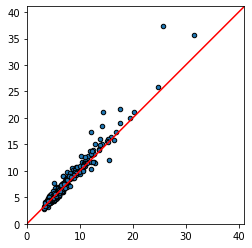

In [9]:

import matplotlib.pyplot as plt

lim = [0, max(*correct, *predictions)*1.1]
plt.scatter(correct, predictions, s=20, linewidths=1, edgecolors='black')
# plt.scatter(correct, predictions, s=20)
plt.gca().set_aspect('equal')
plt.gca().set_xlim(lim)
plt.gca().set_ylim(lim)
# plt.xscale('log')
# plt.yscale('log')
plt.plot([0, lim[1]], [0, lim[1]], color='red')
plt.show()

In [ ]:
torch.save(model.state_dict(), "PLD_CNN_150_epochs_2-2-23_2.pt")